## Notes
- pupil diameter should be under 100
- save video with option of either box or contour
- player as black and white with colored outline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pupilize   # have `pupilize.py` in same directory as this notebook
import player

# install OpenCV:
#   `conda install -c conda-forge opencv`
#   In Windows, make sure you are using the Anaconda Prompt and not the normal Windows command prompt
import cv2

In [2]:
# Depending on version of OpenCV, you may need to change pupilize.py to account for output of function findContours.
# One version will output 2 values while another 3. findContours is used twice in pupilize.py (line 36 & 51).
#   contours, _ = cv2.findContours(frame.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#   _, contours, _ = cv2.findContours(frame.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.__version__

'3.4.1'

In [10]:
video_file = 'PN37B_baseline_10min-10152020171459-0000.avi'

# Parameters to change
#   invert: True for black pupil, False for bright pupil
#   threshold: brightness level between pupil and white of eye
#   morph_kernel: can tweak if needed. larger values will "blur" the pupil edge more. Maybe don't go above 10.
invert = True
threshold = 60
morph_kernel = np.ones(3)

In [11]:
pupil_diam = []
boxes = []
cnts = []
frame_num = 0

cap = cv2.VideoCapture(video_file)
while True:
# for ax in axes.flatten():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    box, cnt = pupilize.find_pupil(frame, invert=invert, threshold=threshold, morph_kernel=morph_kernel)    
    pupil_diam.append(box[2])
    boxes.append(pupilize.box2roi(box))
    cnts.append(cnt)

    frame_num += 1

pupil_diam = np.array(pupil_diam)

# Run again to get frames into array (probably could run with previous loop)
# Done since I want to define an empty array to fill but don't know how many frames until now.
frames = np.zeros((frame_num, ) + (220, 220))
n = 0

cap = cv2.VideoCapture(video_file)
while True:
# for ax in axes.flatten():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frames[n] = frame
    n += 1

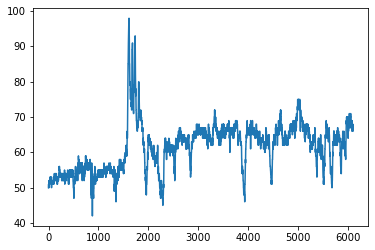

In [13]:
# 100 seems to be a good cutoff to be suspicious that data is not real
plt.plot(pupil_diam)
# np.savetxt('pupil.csv', pupil_diam)

In [14]:
# Open in video player
player.play(frames, roi=boxes, roi_color=[1, 0.5, 0], cmap='gray')

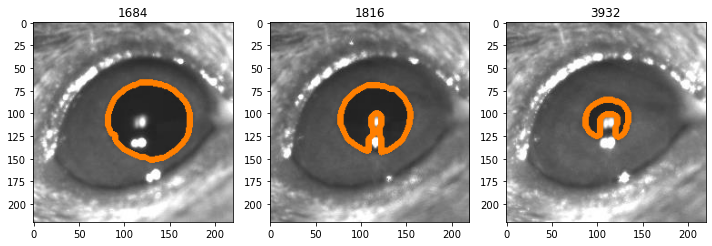

In [15]:
# Sample frames to plot
f_nums = [1684, 1816, 3932]

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for ax, f_num in zip(axes, f_nums):
    im = frames[f_num].copy().astype(np.uint8)
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    cv2.drawContours(im, [cnts[f_num]], -1, (255, 127, 0), 5)
    ax.imshow(im, cmap='gray')
    ax.set_title(f_num)
    
fig.tight_layout()
fig.savefig('pupils.png')